## Configuration

In [3]:


import os
import time
import cv2
import datetime
from IPython import display
import pathlib
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


''' warnings off '''
import warnings
warnings.filterwarnings("ignore")



''' configuration (directly from the research paper) '''
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1
BUFFER_SIZE = 400
OUTPUT_CHANNELS = 3
LAMBDA = 100

dataset_name = "facades"
_URL = f'/kaggle/input/pix2pix-dataset/{dataset_name}/{dataset_name}/'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Dataset

In [5]:


# dataset_name = "facades"
# _URL = f'/kaggle/input/pix2pix-dataset/{dataset_name}/{dataset_name}/'


# '''
#     THe dataset contains three different sections namely "train", "test", "val" sets needed to be loaded seprately.
#     Three separate arrays storing the decoded images
# '''

# def read_decode_images(dirname, filename_arr):
#     decoded_images = []
#     for filename in filename_arr:
#         image_path = os.path.join(dirname, filename)
#         image = tf.io.read_file(image_path)
#         image = tf.io.decode_jpeg(image)
        
#         decoded_images.append(image)
    
#     return decoded_images


# # train_images
# train_path = os.path.join(_URL, "train")
# train_images = read_decode_images(train_path, os.listdir(train_path))

# # test_images
# test_path = os.path.join(_URL, "test")
# test_images = read_decode_images(test_path, os.listdir(test_path))

# # val_images
# val_path = os.path.join(_URL, "val")
# val_images = read_decode_images(val_path, os.listdir(val_path))

'\nThis code has been updated in the next few cells. Read this part of function and\nview this cell and above images to understand the problem behind this\n\n'

In [6]:
# # Checking dimensionality
# print(f"train_images_dimenions : {np.array(train_images).shape}")
# print(f"test_images_dimenions : {np.array(test_images).shape}")
# print(f"val_images_dimenions : {np.array(val_images).shape}")

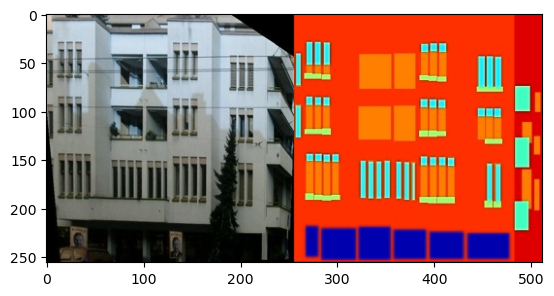

In [7]:
# Image review

plt.figure()
img = cv2.imread(str(pathlib.Path(_URL) / 'train/1.jpg'))
plt.imshow(img)
plt.show()

In [8]:



def read_decode_image(image):
    
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)

    image_division_val = tf.shape(image)[1]
    image_division_val = image_division_val // 2

    input_image = image[:, image_division_val:, :]
    real_image = image[:, :image_division_val, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

## Preprocessing images (according to pix2pix GAN research paper)

In [9]:





def resize_image(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image


# 2) Cropping back to inital dimensions

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image ,real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]


# 3) Normalizing the images

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image


# 4) Random mirroing

@tf.function()
def random_jitter(input_image, real_image):
    
    # Resizing to 286x286
    input_image, real_image = resize_image(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [10]:


def transform_train_dataset(dataset):
    
    input_image, real_image = read_decode_image(dataset)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

def transform_test_dataset(dataset):
    
    input_image, real_image = read_decode_image(dataset)
    input_image, real_image = resize_image(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [11]:
# Pipeline creation for creating tensorflow datasets and preprocessing them using the custom functions

train_dataset = tf.data.Dataset.list_files(str(pathlib.Path(_URL) / 'train/*.jpg'))
train_dataset = train_dataset.map(transform_train_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


test_dataset = tf.data.Dataset.list_files(str(pathlib.Path(_URL) / 'test/*.jpg'))
test_dataset = test_dataset.map(transform_test_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


val_dataset = tf.data.Dataset.list_files(str(pathlib.Path(_URL) / 'val/*.jpg'))
val_dataset = val_dataset.map(transform_test_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Generator Model

In [12]:
'''
    The Generator model used in the Conditional GAN is U-Net which is widely used in cases of image segmentation
    We will be separately defining the downsampler/encoder of the U-Net and upsampler/decoder of the U-Net model
    
    Steps for creating the generator
    
    1) downsampler / encoder
    2) upsampler / decoder
    3) stacking both parts and using skip connections
    
'''


# Downsample/Encoder

def downsample(filters, size, apply_batchnorm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    downsampler = keras.Sequential()
    downsampler.add(keras.layers.Conv2D(
        filters,
        size,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        use_bias=False
    ))
    if apply_batchnorm:
        downsampler.add(tf.keras.layers.BatchNormalization())
    downsampler.add(tf.keras.layers.LeakyReLU())

    return downsampler



# Upsample/Decoder

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    upsampler = tf.keras.Sequential()
    upsampler.add(tf.keras.layers.Conv2DTranspose(
        filters,
        size,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False
    ))

    upsampler.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        upsampler.add(tf.keras.layers.Dropout(0.5))

    upsampler.add(tf.keras.layers.ReLU())

    return upsampler



# Generator model (combining both encoder and decoder using skip connections)

def Generator():
    inputs = keras.layers.Input(shape=[256,256,3]) # (batch_size, 256, 256, 3)
    
#     encoder stack 
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]
    
#     decoder stack
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4, strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh"
    ) # (batch_size, 256, 256, 3)
    
    
# for downsampling and upsampling
    x = inputs
    
#     Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    
#    Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)   

    
    return keras.Model(inputs=inputs, outputs=x)


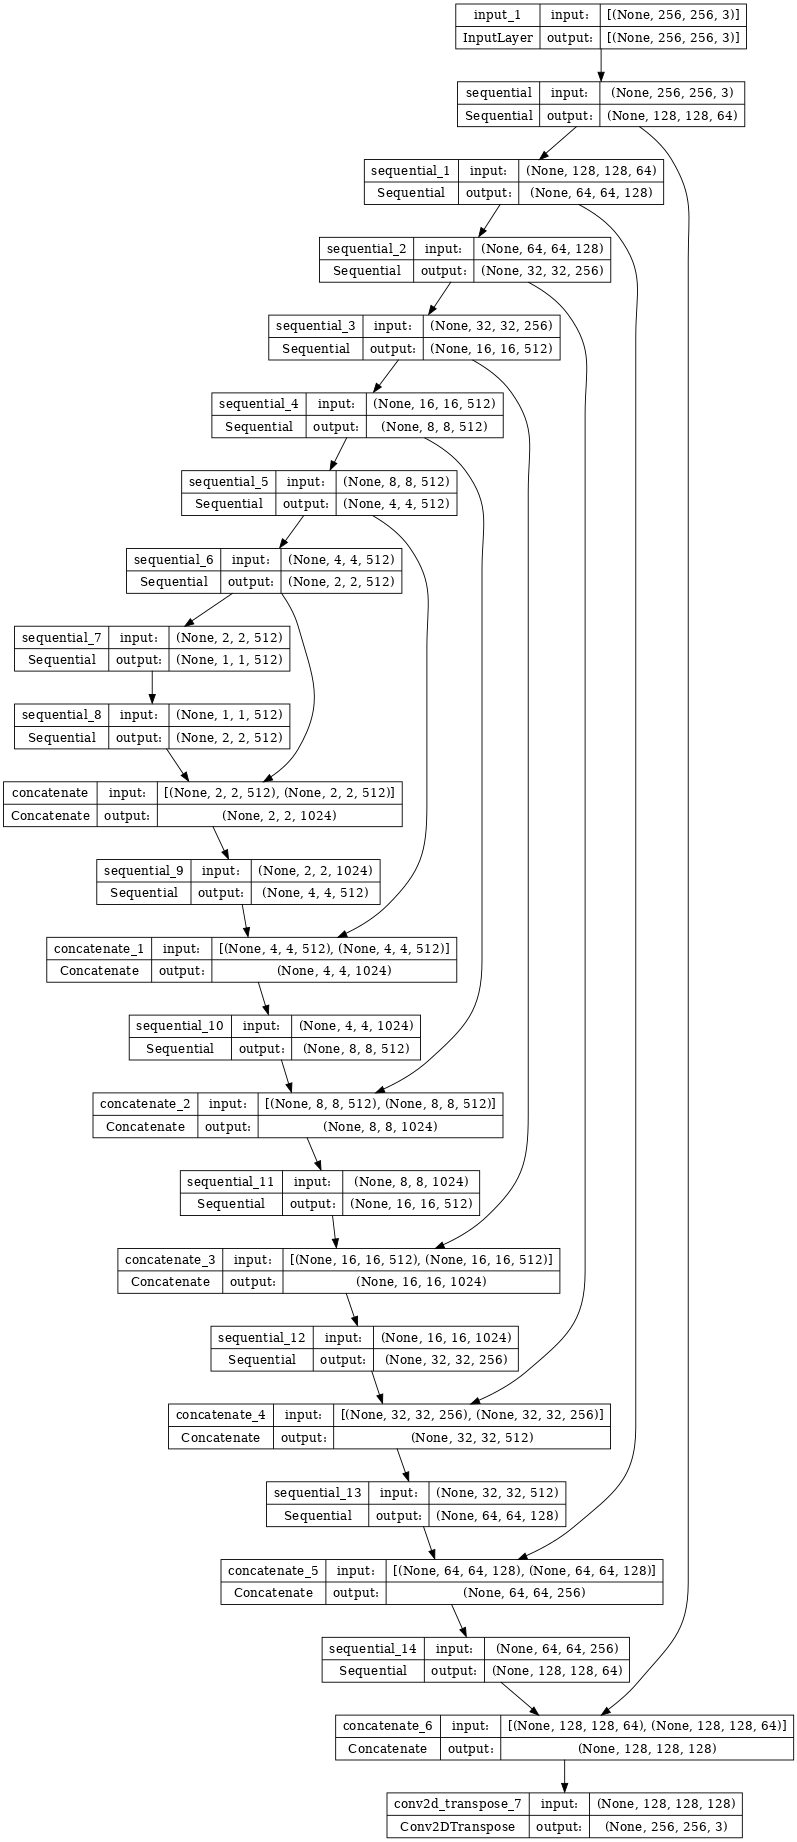

In [13]:
generator = Generator()
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

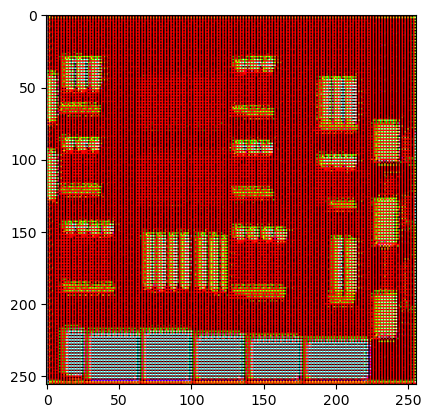

In [14]:
''' testing the generator '''

input_img, real_img = read_decode_image(str(pathlib.Path(_URL) / 'train/1.jpg'))
gen_output = generator(input_img[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Generator Loss Updation

In [15]:
# Loss function initialization

'''

'''

loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Discriminator

In [16]:
def Discriminator():
    
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = keras.layers.Input(shape=[256,256,3], name="input_image")
    tar = keras.layers.Input(shape=[256,256,3], name="target_image")
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                    kernel_initializer=initializer,
                                    use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4,
        strides=1,
        kernel_initializer=initializer
    )(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

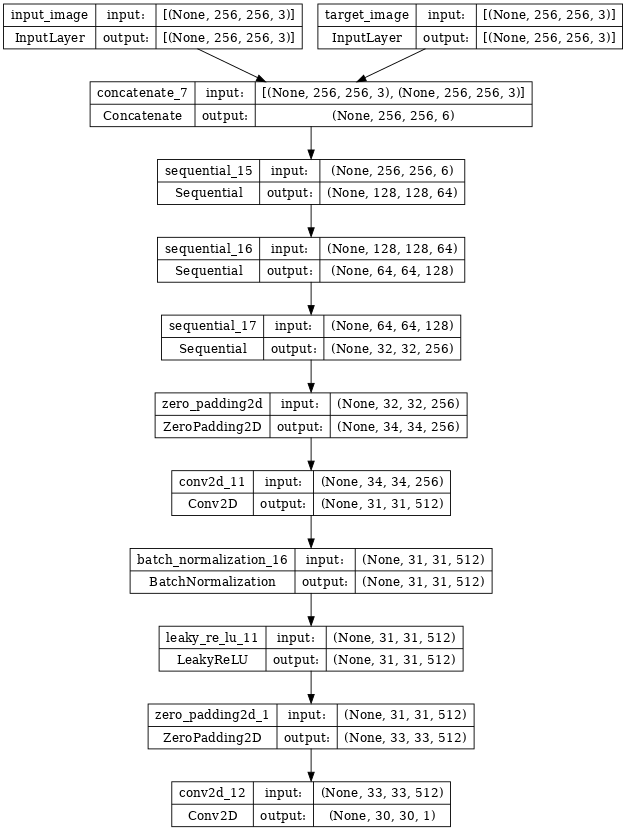

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

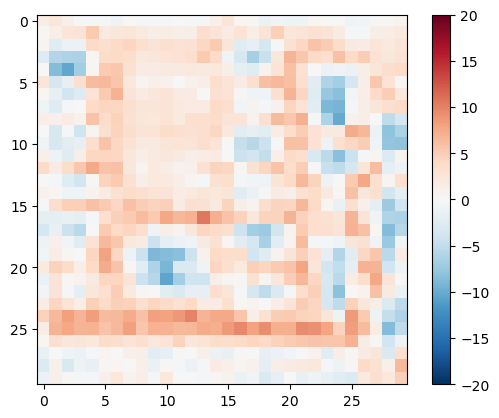

In [18]:
''' testing the discriminator '''

disc_out = discriminator([input_img[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Discriminator Loss Updation

In [19]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output) # for true images
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output) # for generated images
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# MODEL TRAINING

## Optimization and Checkpoints

In [20]:
''' optimizers for both generator and discriminator '''
generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)


''' checkpoints for saving weights and observing the loss function with number of epochs '''
checkpoint_dir = "/kaggle/working/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Custom image generating function and testing

In [21]:
def generate_images(model, test_input, tar):
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
''' testing the custom image generating function '''

for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## Training

In [ ]:
# Logs output

logs_dir = "/kaggle/working/logs/"
summary_writer = tf.summary.create_file_writer(logs_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
'''
    describes each training step of the complete training loop.
    takes input-image, taget-image and the number of step as parametric input
    and updates weights according to the calculated losses

'''

@tf.function
def train_step(input_image, target, step):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

### Custom fit model function

In [ ]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
''' Running for 400 steps '''
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

In [ ]:
# Stay Safe!